In [176]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp
from colorsys import hsv_to_rgb, rgb_to_hsv

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [2]:
datafiles = ['../../allan_data/weighted_graph_bluetooth.edgelist',
             '../../allan_data/weighted_graph_call.edgelist',
             '../../allan_data/weighted_graph_sms.edgelist'] 

In [3]:
gca = nx.read_edgelist(datafiles[1], create_using=nx.DiGraph())

In [4]:
dfca = nx.to_pandas_adjacency(gca)

# Measures

In [5]:
def alpha_weighted(g, u, v, alpha):
    u_edges = g[u]
    u_edges_sum = sum(u_edges[v]['weight']**alpha for v in u_edges)
    return u_edges[v]['weight']**alpha / u_edges_sum 

In [6]:
alpha_weighted(gca, 'u0182', 'u0034', 0)

0.25

In [7]:
alpha_weighted(gca, 'u0182', 'u0034', 1)

0.040268456375838924

In [8]:
gca.get_edge_data('u0182', 'u0034')

{'weight': 6}

In [9]:
gca['u0182'] 

AtlasView({'u0034': {'weight': 6}, 'u0083': {'weight': 1}, 'u0614': {'weight': 117}, 'u0697': {'weight': 25}})

In [10]:
gca_u0182 = {k: v['weight'] for (k, v) in gca['u0182'].items()}
gca_u0182

{'u0034': 6, 'u0083': 1, 'u0614': 117, 'u0697': 25}

In [11]:
len(gca_u0182)

4

In [12]:
sum(gca_u0182.values())

149

In [13]:
6/149

0.040268456375838924

# For plotting

In [14]:
shades_of_green = ['rgb(199, 231, 199)',
                   'rgb(163, 216, 163)',
                   'rgb(127, 201, 127)',
                   'rgb(91, 186, 91)',
                   'rgb(67, 159, 67)',
                   'rgb(52, 123, 52)'] 

# Process call edgelist

Load call data as a DiGraph

Remove selfloops

In [17]:
gca.remove_edges_from(gca.selfloop_edges()) 

Normalize weights

In [18]:
gca2 = gca.copy() 
for edge in gca.edges:
    normed_weight = (alpha_weighted(gca, *edge, alpha=1))
    gca2.edges[edge]['weight'] = normed_weight
gca = gca2

Cast to undirected graph, combining the weights of $a \rightarrow b$ and $b \rightarrow a$.

In [54]:
gca_ud = graph.nxDiGraph2Graph(gca)

Remove weak links, and potentially isolated nodes

In [55]:
keep_edges = [k for (k,v) in nx.get_edge_attributes(gca_ud, 'weight').items() if v > 0.01]
gca_ud = gca_ud.edge_subgraph(keep_edges).copy() 
gca_ud.remove_nodes_from(list(nx.isolates(gca_ud)))

Remove nodes not present in gca_ud from gca, assign to gca_plot

In [56]:
gca_plot = gca.subgraph(gca_ud.nodes).copy() 

![https://assets-cdn.github.com/images/icons/emoji/unicode/1f53a.png](https://assets-cdn.github.com/images/icons/emoji/unicode/1f53a.png) **<font color="crimson">For some reason Igraph can't plot weighted graphs, but it can do unweighted graphs, which can be styled using the weighted attributes.</font>**

In [59]:
DO_LAYOUT_PLOTS = False
if DO_LAYOUT_PLOTS:
    layouts = [el for el in dir(ica_plot) if (el.startswith('layout_') and '3d' not in el)]
    for lay in layouts:
        try:
            numlay = getattr(ica_plot, lay)()
            ig.plot(ica_plot, f'layouts/{lay}.pdf', layout=numlay)
        except:
            print(f"Failed for {lay}.") 

    print(layouts)

Downsample the network for nicer plotting.

Do this on degree (or weights) instead!

In [64]:
np.random.seed(113)
keep_for_plot = list()
for node in gca_plot.nodes:
    degree = gca_plot.degree(node)
    in_degree = gca_plot.in_degree(node)
    out_degree = gca_plot.out_degree(node)
    if degree < 10:
        if np.random.rand() >= 0.95:
            keep_for_plot.append(node)
    else:
        keep_for_plot.append(node) 

In [65]:
len(keep_for_plot)

306

In [66]:
len(gca.nodes)

775

Get subgraph with `keep_for_plot` nodes, and remove potential isolates.

In [68]:
gca_plot_downsampled = gca.subgraph(keep_for_plot).copy() 
gca_plot_downsampled.remove_nodes_from(list(nx.isolates(gca_plot_downsampled))) 

This code removes weak links, which might arise as a result of removing around half of the nodes from the network for the downsampling.

```
keep_edges = [k for (k,v) in nx.get_edge_attributes(gca_ud, 'weight').items() if v > 0.01]
gca_ud = gca_ud.edge_subgraph(keep_edges).copy() 
gca_ud.remove_nodes_from(list(nx.isolates(gca_ud)))
```

In [182]:
gca_plot_downsampled_und = graph.nxDiGraph2Graph(gca_plot_downsampled) 

In [183]:
ica_plot = graph.nx2ig(gca_plot_downsampled_und)

nd = misc.DualDict({v['name']: v.index for v in ica_plot.vs})

In [184]:
ica_plot.is_directed() 

False

Set link color and width

In [142]:
for link in ica_plot.es:
    link['width'] = 10
    u = nd[link.source]
    v = nd[link.target]
    link['undirected_weight'] = gca_plot_downsampled_und.get_edge_data(u, v)['weight'] 
    link['width'] = 3*np.sqrt(gca_plot_downsampled_und.get_edge_data(u, v)['weight'])


In [172]:
min_ud_weight = min(ica_plot.es['undirected_weight'])
max_ud_weight = max(ica_plot.es['undirected_weight'])
min_gray = 110
max_gray = 190 
rgb_gray_str = 'rgb({gv}, {gv}, {gv})'
for link in ica_plot.es:
    gv = int(link['undirected_weight']*(max_gray - min_gray) + min_gray) 
    link['color'] = rgb_gray_str.format(gv=gv)
    


Set node size and color proportional to incomming edge weight summed up

In [225]:
min_node_size = 6
v_min = 0.45
v_max = 0.999
h, s, v = rgb_to_hsv(*colorcycle[0]) 
weight_sum_list = list()
for user in ica_plot.vs:
    name = user.attributes()['name']
    in_edges = gca_plot_downsampled.in_edges(name)
    query_edges = [(a, name) if a != name else b for a, b in in_edges] 
    weight_sum = sum(gca_plot_downsampled.get_edge_data(*edge)['weight'] for edge in query_edges)
    incoming_conn_weights = max(min_node_size, 8*weight_sum)
    user['size'] = incoming_conn_weights
    weight_sum_list.append(weight_sum)  # keep it in order to normalize for colorspace mapping
    
for user in ica_plot.vs:
    name = user.attributes()['name']
    in_edges = gca_plot_downsampled.in_edges(name)
    query_edges = [(a, name) if a != name else b for a, b in in_edges] 
    weight_sum = sum(gca_plot_downsampled.get_edge_data(*edge)['weight'] for edge in query_edges) / max(weight_sum_list)
    vv = (1 - weight_sum)*(v_max - v_min) + v_min
    rgb = [int(el*255) for el in hsv_to_rgb(h, s, vv)]
    user['color'] = 'rgb({}, {}, {})'.format(*rgb)

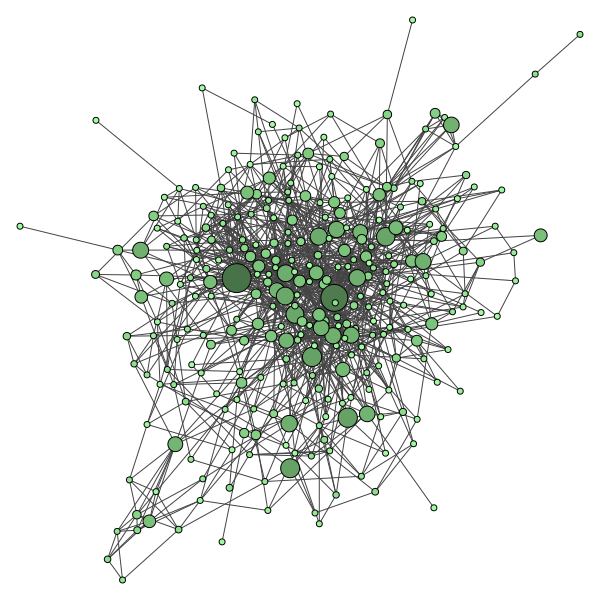

In [226]:
ig.plot(ica_plot)